# Sarima Results

Below contains the results from the first pass at SARIMA modeling.

Feel free to scroll down to 'Analyzing Results'

In [62]:
figures_file_loc = '../reports/figures/arima_results/'

In [63]:
import statsmodels as sm
sm.__version__

'0.10.0'

In [64]:
import numpy as np
import pandas as pd
import pmdarima as pm

import os.path
from os import path
import numpy as np
import pickle
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [65]:
def smape_error(forecast, actual):
    numerator = np.absolute(forecast-actual)
    denominator = np.absolute(forecast) + np.absolute(actual)

    num_samples = len(numerator)

    return 100/num_samples * np.sum(numerator/denominator)

In [66]:
data_dir = '../data/'

In [67]:
df = pd.read_pickle(data_dir+'interim/1hr.pkl').replace([np.inf, -np.inf], np.nan).dropna()
df.reset_index(inplace=True)

df_surrounds = pd.read_pickle(data_dir+'processed/1hr_1block-average.pkl').replace([np.inf, -np.inf], np.nan).dropna()
df_surrounds.reset_index(inplace=True)

blockface_detail = pd.read_csv(data_dir+'raw/blockface_detail.csv')


In [68]:
df['Dummy'] = 0
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose':-1, 
}

In [69]:
start_date = '2019-01-01'
baseline_columns = ['Dummy', 'SourceElementKey']



row_dicts = []

for block in blockface_detail.sourceelementkey.values[:100]:
    block_file = '../arima_results/attempt1/arima.%d.pkl' % block
    if path.exists(block_file):
        
        # select only data for block, timeframe
        mask = (df['SourceElementKey'] == block) & (df['OccupancyDateTime'] > (start_date))
        curr = df[mask].set_index('OccupancyDateTime')
        
        # find number of time chunks per day
        time_chunks_per_day = curr.groupby(curr.index.dayofyear).count().SourceElementKey.max()
        
        
        pct_occupied = curr.PercentOccupied

        num_split = int(.7*len(pct_occupied))

        train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
        df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]
        
        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)
  
        preds = mdl.predict(n_periods=test.shape[0])
        mdl_dict = mdl.to_dict()



        # caluclate arima smape error
        arima_smape = smape_error(preds, test)


        
        # Build a Gradient Boost Model, but with no parameters. This should just 'predict' as the mean value


        lgb_train = lgb.Dataset(data=df_train[baseline_columns], 
                                label=df_train['PercentOccupied'], 
                                feature_name=baseline_columns, 
                               params={'verbose': -1})
        lgb_test = lgb.Dataset(data=df_test[baseline_columns], 
                               label=df_test['PercentOccupied'], 
                               feature_name=baseline_columns, 
                               reference=lgb_train,
                              params={'verbose': -1})
        gbm = lgb.train(params,
                    lgb_train,
                   valid_sets=lgb_test,
                       verbose_eval=False)
        
        # calculate errors
        gbm_pred = gbm.predict(df_test[baseline_columns], num_iteration=gbm.best_iteration)
        gbm_smape = smape_error(gbm_pred, df_test['PercentOccupied'])
        ar_rmse = np.sqrt(mean_squared_error(test, preds))
#         print("Test RMSE: %.3f\t SMAPE: %.3f\t GBM SMAPE: %.3f" % (
#             arima_rmse, arima_smape, gbm_smape))
        

        #compare to within radius
        #df_surrounds
        s_mask = (df_surrounds['SourceElementKey'] == block) & (df_surrounds['OccupancyDateTime'] > (test.index[0]))
        s_curr = df_surrounds[s_mask].set_index('OccupancyDateTime')
        surrounds_test =  s_curr.PercentOccupied
        
        # Append Results
        row_dicts.append( {'SourceElementKey':block,
                                'ArimaSmapeErrors': arima_smape,
                                'GBMSmapeErrors':gbm_smape,
                                'TrainingSetLength':num_split,
                                 'ArimaRMSEs':ar_rmse,
                                 'ModelOrder':(mdl_dict['order'], mdl_dict['seasonal_order']),
                                 'TestVals':test,
                                 'ArimaPreds':preds,
                                 'GBMPreds':gbm_pred,
                                 'SurroundsTest':surrounds_test,
                                })


In [70]:
arima1_results = pd.DataFrame(row_dicts)
arima1_results.set_index('SourceElementKey', inplace=True)
#print(np.mean(arima_smapes), np.mean(gbm_smapes))

In [71]:
arima1_results[['ArimaSmapeErrors', 'GBMSmapeErrors']].mean()


ArimaSmapeErrors    29.557592
GBMSmapeErrors      28.724142
dtype: float64

In [72]:

arima1_results[['NonSeasonal', 'Seasonal']] = pd.DataFrame(arima1_results['ModelOrder'].tolist(), index=arima1_results.index) 
arima1_results[['p', 'd', 'q']] = pd.DataFrame(arima1_results['NonSeasonal'].tolist(), index=arima1_results.index)
arima1_results[['P', 'D', 'Q', 'm']] = pd.DataFrame(arima1_results['Seasonal'].tolist(), index=arima1_results.index)



In [73]:
arima1_results.head()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,ModelOrder,TestVals,ArimaPreds,GBMPreds,SurroundsTest,NonSeasonal,Seasonal,p,d,q,P,D,Q,m
SourceElementKey,,,,,,,,,,,,,,,,,,
1001,30.826774,34.434702,1427,0.233241,"((3, 1, 3), (2, 0, 2, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.247...,"[0.2577023798038323, 0.24653642150740354, 0.13...","[0.29248498129242667, 0.29248498129242667, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.389...,"(3, 1, 3)","(2, 0, 2, 10)",3,1,3,2,0,2,10
1002,30.916092,37.279208,1427,0.196573,"((1, 1, 1), (1, 0, 1, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.237...,"[0.2715980563274346, 0.29349456991501777, 0.05...","[0.27232191637687037, 0.27232191637687037, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.371...,"(1, 1, 1)","(1, 0, 1, 10)",1,1,1,1,0,1,10
1006,23.858915,33.132488,1696,0.172062,"((0, 0, 0), (4, 0, 2, 12))",OccupancyDateTime 2019-06-21 13:00:00 0.507...,"[0.505825766330487, 0.342148345180791, 0.23697...","[0.3211730913292586, 0.3211730913292586, 0.321...",OccupancyDateTime 2019-06-21 14:00:00 0.350...,"(0, 0, 0)","(4, 0, 2, 12)",0,0,0,4,0,2,12
1009,35.346899,38.520762,1712,0.219138,"((1, 1, 1), (3, 0, 3, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.436...,"[0.4584787389367411, 0.4364527174875822, 0.187...","[0.29087346552916865, 0.29087346552916865, 0.2...",OccupancyDateTime 2019-06-20 18:00:00 0.547...,"(1, 1, 1)","(3, 0, 3, 12)",1,1,1,3,0,3,12
1010,19.594693,24.154482,1712,0.226841,"((1, 1, 1), (1, 0, 1, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.620...,"[0.6189713903016867, 0.5709288061900389, 0.341...","[0.5597597884610469, 0.5597597884610469, 0.559...",OccupancyDateTime 2019-06-20 18:00:00 0.488...,"(1, 1, 1)","(1, 0, 1, 12)",1,1,1,1,0,1,12


In [74]:
arima1_results.describe()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,p,d,q,P,D,Q,m
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0000,100.000000,100.0,100.000000,100.000000
mean,29.557592,28.724142,1640.970000,0.258795,1.060000,0.560000,1.0600,2.010000,0.0,2.010000,11.800000
std,16.334520,12.006745,245.225827,0.136547,1.071391,0.498888,0.9081,1.068323,0.0,1.096321,0.963998
min,9.519525,11.706106,251.000000,0.023700,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,10.000000
25%,19.335104,20.049772,1702.750000,0.195207,0.000000,0.000000,0.7500,1.000000,0.0,1.000000,12.000000
50%,23.258682,24.685805,1713.000000,0.231012,1.000000,1.000000,1.0000,2.000000,0.0,2.000000,12.000000
75%,35.991777,35.348371,1713.000000,0.281560,1.250000,1.000000,1.0000,3.000000,0.0,2.250000,12.000000
max,92.033181,75.236908,1999.000000,1.061973,6.000000,1.000000,4.0000,6.000000,0.0,6.000000,14.000000


# Analyzing Results

Let's take a look at the results and see how the Sarima Results compare to predicting simply based on the mean (SIMPLE):

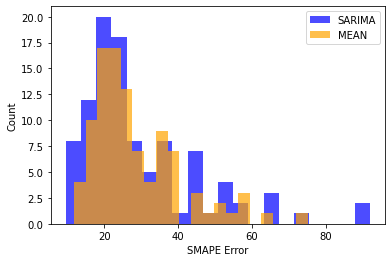

In [117]:
fig, ax = plt.subplots()
ax.hist(arima1_results['ArimaSmapeErrors'], bins=20,color = 'b', alpha = .7, label='SARIMA')
ax.hist(arima1_results['GBMSmapeErrors'], bins=20, color = 'orange', alpha = .7, label='MEAN')
ax.set_xlabel('SMAPE Error')
ax.set_ylabel('Count')
plt.legend()
plt.savefig(figures_file_loc+'sarima_with_differencing_smape_error_histogram.png')

Looking at the figure above, it appears that using SARIMA gives better errors for some blocks, and worse errors for other blocks. I shall inspect the data further to see what may be causing this.

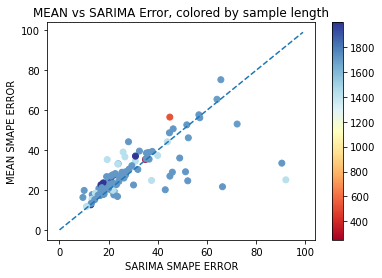

In [76]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima1_results['ArimaSmapeErrors'], 
                arima1_results['GBMSmapeErrors'], 
                c=arima1_results['TrainingSetLength'], cmap=cm)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('MEAN SMAPE ERROR')
ax.set_title('MEAN vs SARIMA Error, colored by sample length')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(100), np.arange(100), '--')
plt.show()

Above, sample size does not appear to be correlated with the error

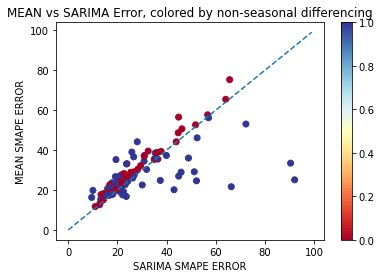

In [77]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima1_results['ArimaSmapeErrors'], 
                arima1_results['GBMSmapeErrors'], 
                c=arima1_results['d'], cmap=cm)
ax.set_title('MEAN vs SARIMA Error, colored by non-seasonal differencing')

ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('MEAN SMAPE ERROR')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(100), np.arange(100), '--')
plt.savefig(figures_file_loc+'sarima_with_differencing_vs_mean_smape_error_scatter.png')

Above, the worst SARIMA model errors are those with a differencing of one. Potentially, allowing no differencing will improve these models. Below, we can see the mean errors for those with and without non-seasonal differencing.

In [78]:
arima1_results[arima1_results['d'] == 0][['ArimaSmapeErrors','GBMSmapeErrors']].mean()

ArimaSmapeErrors    28.120267
GBMSmapeErrors      30.984597
dtype: float64

In [79]:
arima1_results[arima1_results['d'] == 1][['ArimaSmapeErrors','GBMSmapeErrors']].mean()

ArimaSmapeErrors    30.686920
GBMSmapeErrors      26.948069
dtype: float64

## Inspecting some individual Blocks

#### Block A

In [80]:
ex_row = arima1_results[arima1_results['ArimaSmapeErrors'] < arima1_results['GBMSmapeErrors']].iloc[0]
ex_row.ModelOrder

((3, 1, 3), (2, 0, 2, 10))

Below is a block that the SARIMA model performs well with. It appears to capture the daily periodicity, but not the spikes on certain days.

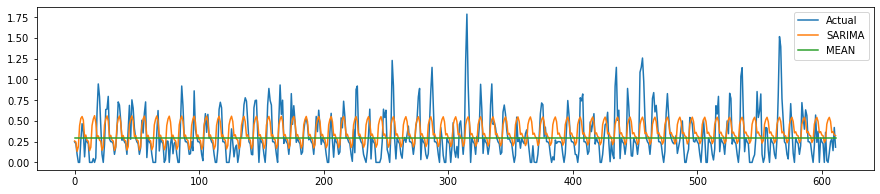

In [81]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row.TestVals.values, label='Actual')
ax.plot(ex_row.ArimaPreds, label='SARIMA')
ax.plot(ex_row.GBMPreds, label='MEAN')
plt.legend()
plt.savefig(figures_file_loc+'sarima_with_differencing_block1.png')


#### Block B

In [82]:
ex_row2 = arima1_results[arima1_results['ArimaSmapeErrors'] > arima1_results['GBMSmapeErrors']].iloc[0]
ex_row2.ModelOrder

((1, 0, 2), (1, 0, 1, 12))

Below is a block that the SARIMA model performs poorly with. The daily trend does not appear as regular as the block above.

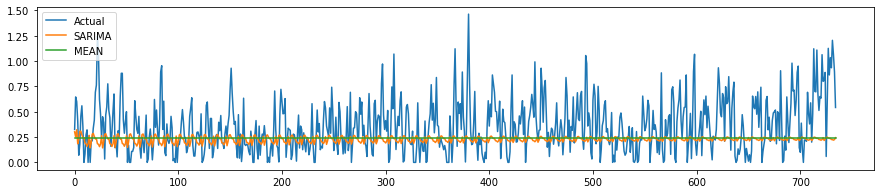

In [83]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row2.TestVals.values, label='Actual')
ax.plot(ex_row2.ArimaPreds, label='SARIMA')
ax.plot(ex_row2.GBMPreds, label='MEAN')
plt.legend()
plt.show()

#### Block C

In [84]:
ex_row3 = arima1_results[(arima1_results['ArimaSmapeErrors'] - arima1_results['GBMSmapeErrors']) > 20].iloc[0]
ex_row3.ModelOrder

((0, 1, 0), (2, 0, 2, 12))

Below is a model with seasonal differencing = 1, which performs quite poorly. We can see that the mean is not trending downwards over time, which leads to a poor SARIMA model with d=1.

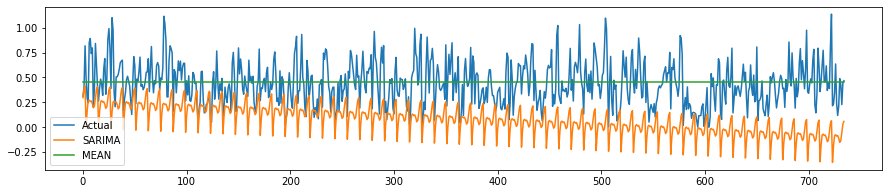

In [85]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row3.TestVals.values, label='Actual')
ax.plot(ex_row3.ArimaPreds, label='SARIMA')
ax.plot(ex_row3.GBMPreds, label='MEAN')
plt.legend()
plt.savefig(figures_file_loc+'sarima_with_differencing_block3.png')

## Next Steps

Things I would like to test out:
   
   * Allowing no differencing (setting $d=0$)
   * Adding Exogenous regressors, to see if this can help predict the spikes (SARIMAX model)
   * Use Tree-based models to predict on the residuals from the SARIMA model
   
Things that may help even out the sharp, potentially random, peaks:

   * Predict based on blocks within certain radius. Potentially, an individual block cannot be predicted so accurately because people may choose to find parking within a certain radius, instead of a specific block.


In [86]:
arima1_results.columns

Index(['ArimaSmapeErrors', 'GBMSmapeErrors', 'TrainingSetLength', 'ArimaRMSEs',
       'ModelOrder', 'TestVals', 'ArimaPreds', 'GBMPreds', 'SurroundsTest',
       'NonSeasonal', 'Seasonal', 'p', 'd', 'q', 'P', 'D', 'Q', 'm'],
      dtype='object')

# Arima 2nd Iteration - No seasonal Differencing

In [87]:
arima2_results = arima1_results.copy().drop(['NonSeasonal', 'Seasonal', 'p', 'd', 'q', 'P', 'D', 'Q', 'm'], axis=1)

In [88]:
arima2_results.head()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,ModelOrder,TestVals,ArimaPreds,GBMPreds,SurroundsTest
SourceElementKey,,,,,,,,,
1001,30.826774,34.434702,1427,0.233241,"((3, 1, 3), (2, 0, 2, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.247...,"[0.2577023798038323, 0.24653642150740354, 0.13...","[0.29248498129242667, 0.29248498129242667, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.389...
1002,30.916092,37.279208,1427,0.196573,"((1, 1, 1), (1, 0, 1, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.237...,"[0.2715980563274346, 0.29349456991501777, 0.05...","[0.27232191637687037, 0.27232191637687037, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.371...
1006,23.858915,33.132488,1696,0.172062,"((0, 0, 0), (4, 0, 2, 12))",OccupancyDateTime 2019-06-21 13:00:00 0.507...,"[0.505825766330487, 0.342148345180791, 0.23697...","[0.3211730913292586, 0.3211730913292586, 0.321...",OccupancyDateTime 2019-06-21 14:00:00 0.350...
1009,35.346899,38.520762,1712,0.219138,"((1, 1, 1), (3, 0, 3, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.436...,"[0.4584787389367411, 0.4364527174875822, 0.187...","[0.29087346552916865, 0.29087346552916865, 0.2...",OccupancyDateTime 2019-06-20 18:00:00 0.547...
1010,19.594693,24.154482,1712,0.226841,"((1, 1, 1), (1, 0, 1, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.620...,"[0.6189713903016867, 0.5709288061900389, 0.341...","[0.5597597884610469, 0.5597597884610469, 0.559...",OccupancyDateTime 2019-06-20 18:00:00 0.488...


In [89]:
start_date = '2019-01-01'
baseline_columns = ['Dummy', 'SourceElementKey']


for block in arima2_results.index.values:
    block_file = '../arima_results/attempt2/arima.%d.pkl' % block
    if path.exists(block_file):
        arima2_results.loc[block]
        test = arima2_results.loc[block].TestVals
        
        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)
        preds = mdl.predict(n_periods=test.shape[0])
        mdl_dict = mdl.to_dict()
        #print(type(preds), len(preds))
        
        arima2_results.at[block, 'ArimaPreds'] = preds
        arima2_results.at[block, 'ModelOrder'] = (mdl_dict['order'], mdl_dict['seasonal_order'])


        # caluclate arima smape error
        arima2_results.at[block, 'ArimaSmapeErrors'] = smape_error(preds, test.values)

        

        
        # calculate errors

        arima2_results.at[block, 'ArimaRMSEs'] = np.sqrt(mean_squared_error(test.values, preds))

#arima1_results['ArimaSmapeErrors_2'] =  arima2_smapes



In [90]:
arima2_results[['NonSeasonal', 'Seasonal']] = pd.DataFrame(arima2_results['ModelOrder'].tolist(), index=arima2_results.index) 
arima2_results[['p', 'd', 'q']] = pd.DataFrame(arima2_results['NonSeasonal'].tolist(), index=arima2_results.index)
arima2_results[['P', 'D', 'Q', 'm']] = pd.DataFrame(arima2_results['Seasonal'].tolist(), index=arima2_results.index)


## Analyzing ARIMA without seasonal differencing

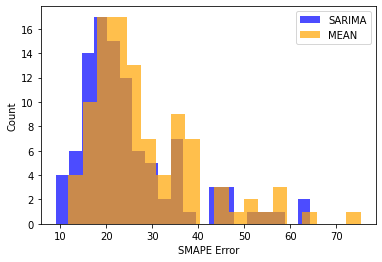

In [118]:
fig, ax = plt.subplots()
ax.hist(arima2_results['ArimaSmapeErrors'], bins=20,color = 'b', alpha = .7, label='SARIMA')
ax.hist(arima2_results['GBMSmapeErrors'], bins=20, color = 'orange', alpha = .7, label='MEAN')
ax.set_xlabel('SMAPE Error')
ax.set_ylabel('Count')
plt.legend()
plt.savefig(figures_file_loc+'sarima_without_differencing_smape_error_histogram.png')

ARIMA model is slightly better than the baseline model, but not much different.

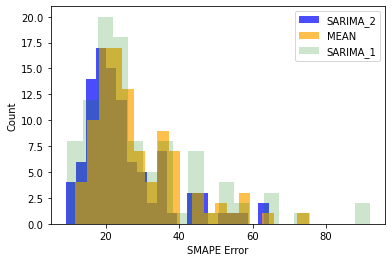

In [92]:
fig, ax = plt.subplots()
ax.hist(arima2_results['ArimaSmapeErrors'], bins=20,color = 'b', alpha = .7, label='SARIMA_2')
ax.hist(arima2_results['GBMSmapeErrors'], bins=20, color = 'orange', alpha = .7, label='MEAN')
ax.hist(arima1_results['ArimaSmapeErrors'], bins=20, color = 'g', alpha = .2, label='SARIMA_1')

ax.set_xlabel('SMAPE Error')
ax.set_ylabel('Count')
plt.legend()
plt.savefig(figures_file_loc+'sarima_comparing_differencing_smape_error_histogram.png')

We can see that the second sarima iteration cuts down on the blocks with high error.

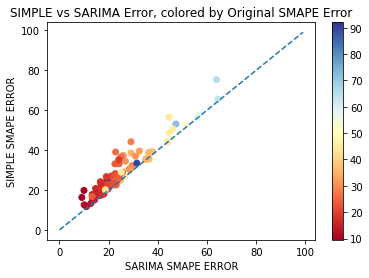

In [93]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima2_results['ArimaSmapeErrors'], 
                arima2_results['GBMSmapeErrors'], 
                c=arima1_results['ArimaSmapeErrors'], cmap=cm)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
ax.set_title('SIMPLE vs SARIMA Error, colored by Original SMAPE Error')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(100), np.arange(100), '--')
plt.savefig(figures_file_loc+'sarima_no_differencing_smape_error_scatter.png')

All of the blocks at least perform slightly better than the baseline prediction

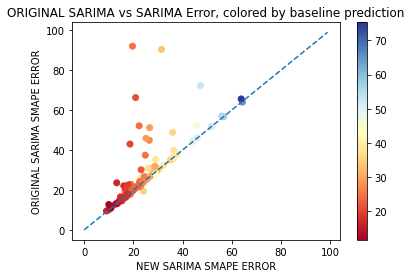

In [94]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima2_results['ArimaSmapeErrors'], 
                arima1_results['ArimaSmapeErrors'],
               c=arima2_results['GBMSmapeErrors'], cmap=cm)
ax.set_xlabel('NEW SARIMA SMAPE ERROR')
ax.set_ylabel('ORIGINAL SARIMA SMAPE ERROR')
ax.set_title('ORIGINAL SARIMA vs SARIMA Error, colored by baseline prediction')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(100), np.arange(100), '--')
plt.savefig(figures_file_loc+'sarima_comparing_differencing_smape_error_scatter.png')

There are certain blocks that the new iteration performs much better than the original SARIMA.

In [95]:
better_than_gbm = arima2_results[arima2_results['ArimaSmapeErrors'] < arima2_results['GBMSmapeErrors']]
row_idx = better_than_gbm.index.values[0]
ex_row_ar2 = better_than_gbm.iloc[0]
ex_row_ar2.ModelOrder

((0, 0, 3), (4, 0, 4, 10))

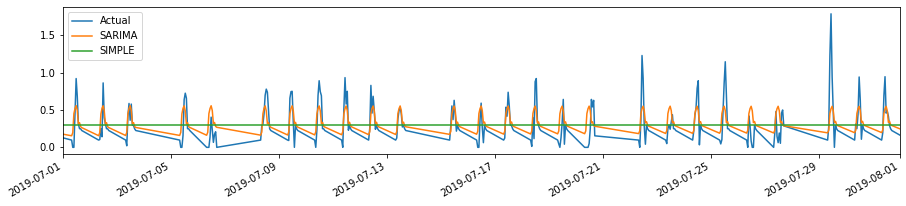

In [96]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row.TestVals, label='Actual')
# ax.plot(ex_row.SurroundsTest, label='Surrounds')
ax.plot(ex_row.TestVals.index, ex_row.ArimaPreds, label='SARIMA')
ax.plot(ex_row.TestVals.index, ex_row.GBMPreds, label='SIMPLE')
ax.set_xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-08-01'))
fig.autofmt_xdate()
plt.legend()
plt.show()

In [116]:
arima2_results[['ArimaSmapeErrors', 'GBMSmapeErrors']].mean()


ArimaSmapeErrors    25.155208
GBMSmapeErrors      28.724142
dtype: float64

In [97]:
# arima2_results.to_pickle('arima_results2/arima_results.pkl')
# arima1_results.to_pickle('arima_results/arima_results.pkl')

# Arima Iteration 3 - Results with 1-block radius averaged observations

In [98]:
start_date = '2019-01-01'
baseline_columns = ['Dummy', 'SourceElementKey']
df_surrounds['Dummy'] = 0


row_dicts = []

for block in blockface_detail.sourceelementkey.values:
    block_file = '../arima_results/attempt3/arima.%d.pkl' % block
    if path.exists(block_file):
        
        # select only data for block, timeframe
        mask = (df_surrounds['SourceElementKey'] == block) & (df_surrounds['OccupancyDateTime'] > (start_date))
        curr = df_surrounds[mask].set_index('OccupancyDateTime')
        
        # find number of time chunks per day
        time_chunks_per_day = curr.groupby(curr.index.dayofyear).count().SourceElementKey.max()
        
        
        pct_occupied = curr.PercentOccupied

        num_split = int(.7*len(pct_occupied))

        train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
        df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]
        
        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)
  
        preds = mdl.predict(n_periods=test.shape[0])
        mdl_dict = mdl.to_dict()



        # caluclate arima smape error
        arima_smape = smape_error(preds, test)


        
        # Build a Gradient Boost Model, but with no parameters. This should just 'predict' as the mean value


        lgb_train = lgb.Dataset(data=df_train[baseline_columns], 
                                label=df_train['PercentOccupied'], 
                                feature_name=baseline_columns, 
                               params={'verbose': -1})
        lgb_test = lgb.Dataset(data=df_test[baseline_columns], 
                               label=df_test['PercentOccupied'], 
                               feature_name=baseline_columns, 
                               reference=lgb_train,
                              params={'verbose': -1})
        gbm = lgb.train(params,
                    lgb_train,
                   valid_sets=lgb_test,
                       verbose_eval=False)
        
        # calculate errors
        gbm_pred = gbm.predict(df_test[baseline_columns], num_iteration=gbm.best_iteration)
        gbm_smape = smape_error(gbm_pred, df_test['PercentOccupied'])
        ar_rmse = np.sqrt(mean_squared_error(test, preds))
#         print("Test RMSE: %.3f\t SMAPE: %.3f\t GBM SMAPE: %.3f" % (
#             arima_rmse, arima_smape, gbm_smape))
        


        
        # Append Results
        row_dicts.append( {'SourceElementKey':block,
                                'ArimaSmapeErrors': arima_smape,
                                'GBMSmapeErrors':gbm_smape,
                                'TrainingSetLength':num_split,
                                 'ArimaRMSEs':ar_rmse,
                                 'ModelOrder':(mdl_dict['order'], mdl_dict['seasonal_order']),
                                 'TestVals':test,
                                 'ArimaPreds':preds,
                                 'GBMPreds':gbm_pred,
                                })


In [99]:
arima3_results = pd.DataFrame(row_dicts)
arima3_results.set_index('SourceElementKey', inplace=True)

In [100]:
arima3_results[['ArimaSmapeErrors', 'GBMSmapeErrors']].mean()


ArimaSmapeErrors    10.442124
GBMSmapeErrors      15.499295
dtype: float64

A 10% error is much better than the previous SARIMA iteration errors (>25%). Additionally, the Arima provides some predictive value, as it is better than the baseline prediction.

In [101]:
arima3_results[['NonSeasonal', 'Seasonal']] = pd.DataFrame(arima3_results['ModelOrder'].tolist(), index=arima3_results.index) 
arima3_results[['p', 'd', 'q']] = pd.DataFrame(arima3_results['NonSeasonal'].tolist(), index=arima3_results.index)
arima3_results[['P', 'D', 'Q', 'm']] = pd.DataFrame(arima3_results['Seasonal'].tolist(), index=arima3_results.index)


In [102]:
arima3_results = arima3_results.join(arima1_results.ArimaSmapeErrors, rsuffix='_org')

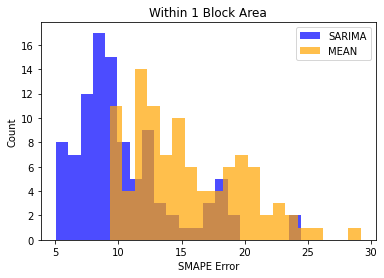

In [103]:
fig, ax = plt.subplots()
ax.set_title('Within 1 Block Area')
ax.hist(arima3_results['ArimaSmapeErrors'], bins=20,color = 'b', alpha = .7, label='SARIMA')
ax.hist(arima3_results['GBMSmapeErrors'], bins=20, color = 'orange', alpha = .7, label='MEAN')
ax.set_xlabel('SMAPE Error')
ax.set_ylabel('Count')
plt.legend()
plt.savefig(figures_file_loc+'sarima_within_radius_smape_error_histogram.png')

A significant decrease in SMAPE error is observed.

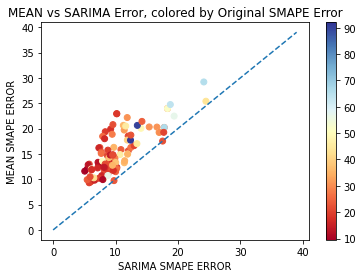

In [104]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima3_results['ArimaSmapeErrors'], 
                arima3_results['GBMSmapeErrors'], 
                c=arima3_results['ArimaSmapeErrors_org'], cmap=cm)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('MEAN SMAPE ERROR')
ax.set_title('MEAN vs SARIMA Error, colored by Original SMAPE Error')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(40), np.arange(40), '--')
plt.savefig(figures_file_loc+'sarima_within_1_block_smape_error_scatter.png')

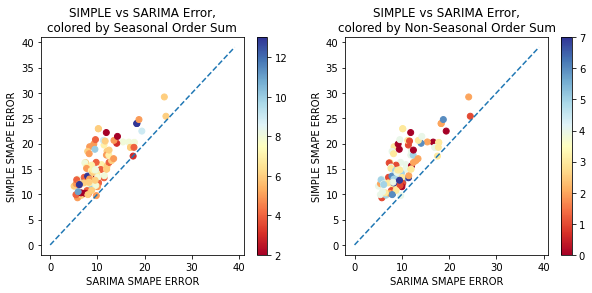

In [105]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (10,4))
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima3_results['ArimaSmapeErrors'], 
                arima3_results['GBMSmapeErrors'], 
                c=arima3_results['P'] + arima3_results['Q'], cmap=cm)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
ax.set_title('SIMPLE vs SARIMA Error,\ncolored by Seasonal Order Sum')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(40), np.arange(40), '--')

im = ax2.scatter(arima3_results['ArimaSmapeErrors'], 
                arima3_results['GBMSmapeErrors'], 
                c=arima3_results['p'] + arima3_results['q'], cmap=cm)
ax2.set_xlabel('SARIMA SMAPE ERROR')
ax2.set_ylabel('SIMPLE SMAPE ERROR')
ax2.set_title('SIMPLE vs SARIMA Error,\ncolored by Non-Seasonal Order Sum')
fig.colorbar(im, ax=ax2)
ax2.plot(np.arange(40), np.arange(40), '--')

plt.show()

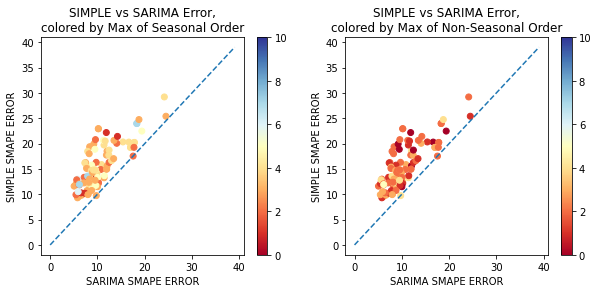

In [106]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (10,4))
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima3_results['ArimaSmapeErrors'], 
                arima3_results['GBMSmapeErrors'], 
                c=np.maximum(arima3_results['P'], arima3_results['Q']), 
                cmap=cm,
               vmin = 0, vmax=10)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
ax.set_title('SIMPLE vs SARIMA Error,\ncolored by Max of Seasonal Order')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(40), np.arange(40), '--')

im = ax2.scatter(arima3_results['ArimaSmapeErrors'], 
                arima3_results['GBMSmapeErrors'], 
                c=np.maximum(arima3_results['p'], arima3_results['q']),                 
                 cmap=cm,
               vmin = 0, vmax=10)
ax2.set_xlabel('SARIMA SMAPE ERROR')
ax2.set_ylabel('SIMPLE SMAPE ERROR')
ax2.set_title('SIMPLE vs SARIMA Error,\ncolored by Max of Non-Seasonal Order')
fig.colorbar(im, ax=ax2)
ax2.plot(np.arange(40), np.arange(40), '--')

plt.show()

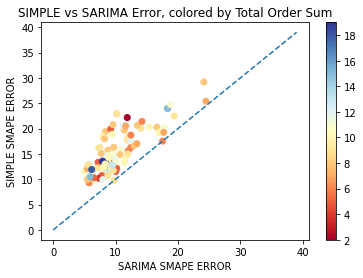

In [107]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima3_results['ArimaSmapeErrors'], 
                arima3_results['GBMSmapeErrors'], 
                c=arima3_results['P'] + arima3_results['Q'] + arima3_results['p'] + arima3_results['q'], cmap=cm)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
ax.set_title('SIMPLE vs SARIMA Error, colored by Total Order Sum')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(40), np.arange(40), '--')
plt.show()

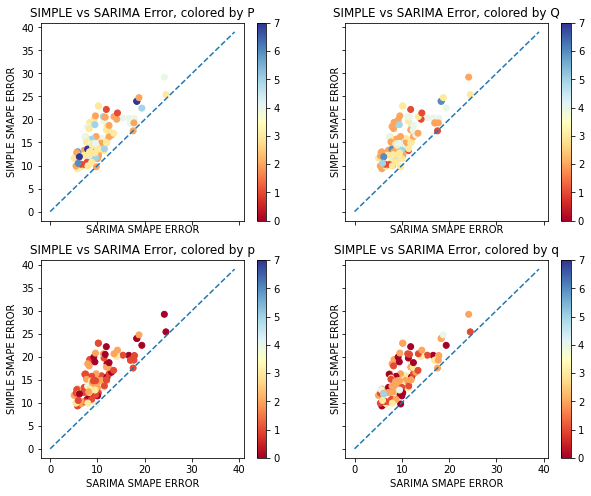

In [108]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize = (10,8))
cm = plt.cm.get_cmap('RdYlBu')

model_orders = ['P', 'Q', 'p', 'q']

for param, ax in zip(model_orders, axs.ravel()):

    im = ax.scatter(arima3_results['ArimaSmapeErrors'], 
                    arima3_results['GBMSmapeErrors'], 
                    c=arima3_results[param], cmap=cm,
                   vmin = 0, vmax=7)
    ax.set_xlabel('SARIMA SMAPE ERROR')
    ax.set_ylabel('SIMPLE SMAPE ERROR')
    ax.set_title('SIMPLE vs SARIMA Error, colored by %s' % param)
    fig.colorbar(im, ax=ax)
    ax.plot(np.arange(40), np.arange(40), '--')
plt.show()

In [109]:
better_than_gbm = arima3_results[arima3_results['ArimaSmapeErrors'] < arima3_results['GBMSmapeErrors']]
row_idx = better_than_gbm.index.values[0]
ex_row = better_than_gbm.iloc[0]
ex_row.ModelOrder

((0, 0, 0), (4, 0, 4, 12))

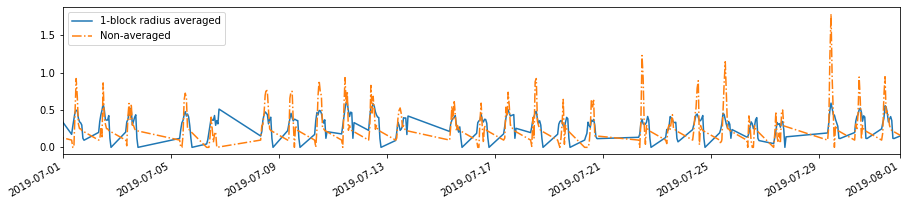

In [111]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row.TestVals, label='1-block radius averaged')
ax.plot(ex_row_ar2.TestVals, '-.', label='Non-averaged')

ax.set_xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-08-01'))
fig.autofmt_xdate()
plt.legend()
plt.show()

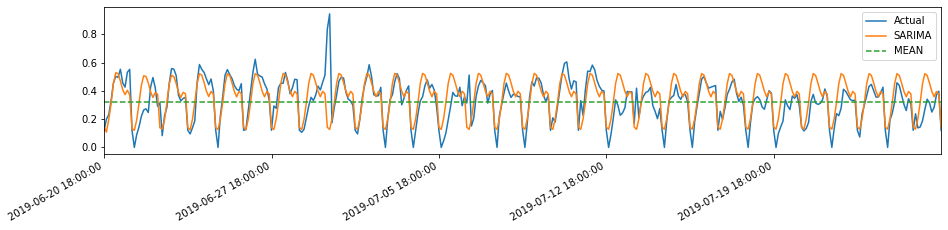

In [112]:
fig, ax = plt.subplots(figsize=(15,3))
time_chunks_per_day = ex_row.TestVals.groupby(ex_row.TestVals.index.dayofyear).count().max()
weeks = 5

ax.plot(ex_row.TestVals.values, label='Actual')
# ax.plot(ex_row.SurroundsTest, label='Surrounds')
ax.plot(ex_row.ArimaPreds, label='SARIMA')
ax.plot(ex_row.GBMPreds, '--', label='MEAN')
ax.set_xlim(0, weeks*time_chunks_per_day*6)
xtick_numbers = np.arange(0, weeks*time_chunks_per_day*6, time_chunks_per_day*6)
ax.set_xticks(xtick_numbers)
ax.set_xticklabels(ex_row.TestVals.index[xtick_numbers])
fig.autofmt_xdate()
plt.legend()
plt.savefig(figures_file_loc+'sarima_within_1block_block1.png')

In [113]:
better_than_gbm = arima3_results[arima3_results['ArimaSmapeErrors'] + 3 < arima3_results['GBMSmapeErrors']]
row_idx = better_than_gbm.sample(n=1).index.values[0]
print(row_idx)
ex_row = arima3_results.loc[row_idx]
ex_row.ModelOrder

2085


((4, 0, 2), (7, 0, 6, 12))

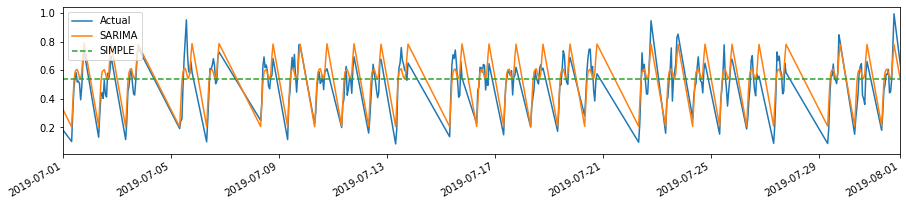

In [115]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row.TestVals, label='Actual')
# ax.plot(ex_row.SurroundsTest, label='Surrounds')
ax.plot(ex_row.TestVals.index, ex_row.ArimaPreds, label='SARIMA')
ax.plot(ex_row.TestVals.index, ex_row.GBMPreds, '--', label='SIMPLE')
ax.set_xlim(pd.Timestamp('2019-07-01'), pd.Timestamp('2019-08-01'))
fig.autofmt_xdate()
plt.legend()
plt.show()

Output results to pickle

In [ ]:
# arima3_results.to_pickle('arima_results3/arima_results.pkl')
